### Figures for colloquium at the University of Rochester in 2018 April.

Links for the tour of the viewer:

* [Galactic Center (DECaPS)](http://legacysurvey.org/viewer?ra=266.41683&dec=-29.0078&zoom=16&layer=decaps)
* Zoom out and switch to WISE, H-alpha, dust layers.  Overlay the constellations.
* [NGC6742 Planetary Nebula](http://legacysurvey.org/viewer/?ra=284.83291667&dec=48.46527778&layer=decals-dr6&zoom=10)
* [UGC12589 Interacting System](http://legacysurvey.org/viewer?ra=351.2607&dec=0.0087&zoom=9&layer=decals-dr5)
* [SDSS/C4 2010 Cluster](http://legacysurvey.org/viewer?ra=29.0707&dec=1.0510&zoom=13&layer=decals-dr5)

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import warnings
from scipy.stats import kde, binned_statistic
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import matplotlib.pyplot as plt

In [2]:
from astropy.io import fits, ascii
from astropy.table import Table

In [3]:
import seaborn as sns
colors = sns.color_palette()
sns.set(context='talk', style='ticks', font_scale=1.5)#, palette='deep')
sns.set_palette('deep', 12)

In [4]:
import legacyhalos.io

In [5]:
%matplotlib inline

In [6]:
talkdir = os.path.join(os.getenv('LEGACYHALOS_DIR'), 'talks', 'rochester-2018apr')
hdefault = 0.7 # 0.677 # Hubble constant

### Some utility functions.

In [7]:
def mstar_label():
    return r'$log_{10}\, (\mathcal{M}\ /\ h^{-2}\, \mathcal{M}_{*})$'

In [8]:
def mstar_label2():
    return r'$log_{10}\, (\mathcal{M}\ /\ h^{-1}\, \mathcal{M}_{*})$'

In [9]:
def phi_label():
    return r'$log_{10}\, (\mathcal{\Phi}\ /\ h^{3}$ Mpc$^{-3}$ dex$^{-1})$'

### Model stellar mass functions

Data taken from Knebe+18.

In [10]:
def read_carnage_smf(fullrange=False, seed=None, h=hdefault):
    """Data taken from Knebe+18."""
    
    carnagedir = os.path.join(os.getenv('CATALOGS_DIR'), 'carnage')
    
    labels = ('DLB07', 'GalICS2.0', 'LGALAXIES', 'SAG', 'MIC3', 
              'SAGE', 'Galform-GP14', 'MORGANA', 'ySAM')    
    data = []
    for model in ('DLB07-c01.txt', 'GalICS2.0-c01.txt', 'LGALAXIES-c01.txt',
                  'SAG-c01.txt', 'MIC3-c01.txt', 'SAGE-c01.txt', 
                  'Galform-GP14-c01.txt', 'MORGANA-c01.txt', 'ySAM-c01.txt'):
        dd = ascii.read(os.path.join(carnagedir, 'Fig.1', model), 
                        format='basic', names=('mstar', 'phi', 'junk1', 'junk2', 'junk3'),
                        exclude_names=('junk1', 'junk2', 'junk3'))
        good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
        dd = dd[good]
        
        dd['mstar'] = np.log10(dd['mstar'] / h)
        dd['phi'] = np.log10(dd['phi'] * h**3)
        data.append(dd)
        
    if fullrange:
        rand = np.random.RandomState(seed)
        
        mstar, phi = [], []
        for dd in data:
            #good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
            mstar.append(dd['mstar']+ rand.normal(loc=0, scale=0.05))
            phi.append(dd['phi'])
        mstar = np.hstack(mstar)
        phi = np.hstack(phi)
        
        width = 0.2
        mstarrange = (9.1, 12.5)
        nbins = np.int(np.ptp(mstarrange) / width)
        
        phimin, mstar_edges, _ = binned_statistic(mstar, phi, statistic='min', bins=nbins, 
                                                  range=mstarrange)
        phimax, _, _ = binned_statistic(mstar, phi, statistic='max', bins=nbins,
                                                  range=mstarrange)
        mstar = mstar_edges[1:] - width / 2
        
        return mstar, phimin, phimax
    else:
        return data, labels

In [11]:
def qa_carnage_smf(individual=True, fullrange=False, png=None):
    fig, ax = plt.subplots(figsize=(10, 7))
    if individual:
        data, labels = read_carnage_smf()
        ls = ('-', '--', '-.', ':')
        for dd, ll in zip(data, labels):
            ax.plot(dd['mstar'], dd['phi'], label=ll, lw=4,
                    ls=ls[0], alpha=0.8)
            ls = np.roll(ls, 1)

    if fullrange:
        mstar, phimin, phimax = read_carnage_smf(fullrange=True, seed=1)
        ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray',
                       label='All CARNage Models')

    ax.grid()
    ax.set_xlabel(mstar_label2())
    ax.set_ylabel(phi_label())
    ax.grid()
    ax.legend(loc='lower left', ncol=2, fontsize=16)
    
    if png:
        plt.savefig(png)

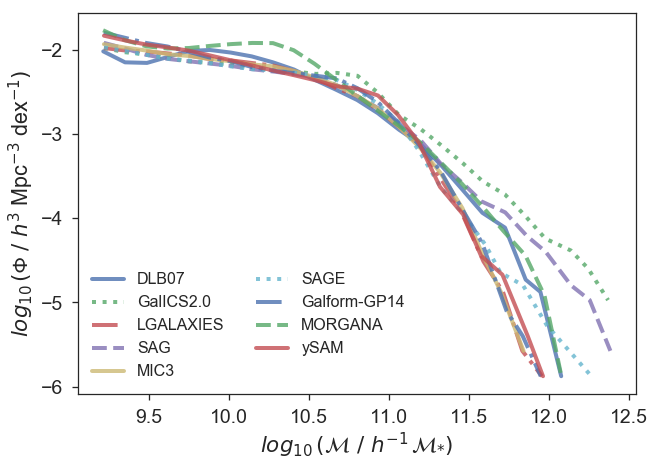

In [12]:
qa_carnage_smf(fullrange=False, png=os.path.join(talkdir, 'smf-carnage.png'))

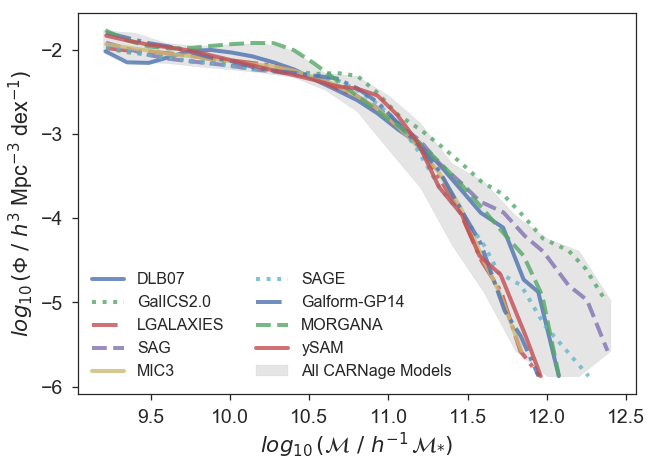

In [13]:
qa_carnage_smf(fullrange=True)

### Observed stellar mass functions

Data taken from Huang+18.

In [14]:
def read_moustakas13():
    """Read data from Moustakas+13."""
    moosedir = os.path.join(os.getenv('CATALOGS_DIR'), '13moustakas')
    
    data = ascii.read(os.path.join(moosedir, 'smf_all_supergrid01.txt'), 
                      format='basic', names=('zlo', 'zhi', 'ngal', 'mstar', 
                                             'limit', 'phi', 'philo', 'phihi', 
                                             'phicv'))
    loz = np.where( data['zhi'] <= 0.2 )[0]
    data = data[loz]
    
    return data['mstar'], data['phi'], data['phi'] - data['phicv'], data['phi'] + data['phicv']

In [15]:
def read_bernardi17(h=hdefault, dustfree=True):
    """Read data from Bernardi+17."""
    moosedir = os.path.join(os.getenv('CATALOGS_DIR'), '17bernardi')
    data = pd.read_table(os.path.join(moosedir, 'smf.txt'), 
                         delim_whitespace=True)

    mstar = data['mstar'].values # - np.log10(h**2)
    if dustfree:
        phi = data['phi_M14_dustfree_obs'].values # + np.log10(h**3)
        philo = phi - data['phierr_M14_dustfree'].values
        phihi = phi + data['phierr_M14_dustfree'].values
    else:
        phi = data['phi_M14_dust_obs'].values # + np.log10(h**3)
        philo = phi - data['phierr_M14_dust'].values
        phihi = phi + data['phierr_M14_dust'].values
    
    return mstar, phi, philo, phihi

In [16]:
def read_huang18(cModel=False, BCG=False, total=False, h=hdefault):
    
    huangdir = os.path.join(os.getenv('CATALOGS_DIR'), '18huang')

    if BCG:
        censuffix = 'cenhighmh'
    else:
        censuffix = 'cenlowmh'
        
    if cModel:
        fluxsuffix = 'cmodel'
    else:
        fluxsuffix = '100kpc'

    if total:
        data = Table.read(os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format('cenhighmh', fluxsuffix)))
        _data = Table.read(os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format('cenlowmh', fluxsuffix)))
        #print(data['logm_mean'], data['smf'].data, _data['smf'].data)
        
        data['smf'] += _data['smf']
        data['smf_err'] = np.sqrt( data['smf_err']**2 + _data['smf_err']**2 )
        data['smf_low'] = np.sqrt( data['smf_low']**2 + _data['smf_low']**2 )
        data['smf_upp'] = np.sqrt( data['smf_upp']**2 + _data['smf_upp']**2 )
    else:
        smffile = os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format(censuffix, fluxsuffix))
        data = Table.read(smffile)
    
    good = np.where( (data['logm_0'] >= 11.4) * (data['smf_err'] > 0) )[0]
    mstar = data['logm_mean'][good] # - 2*np.log10(h)
    phi = np.log10(data['smf'][good]) # * h**3)
    phierr = data['smf_err'][good] / data['smf'][good] / np.log(10)
    philo = phi - data['smf_low'][good] / data['smf'][good] / np.log(10)
    phihi = phi + data['smf_upp'][good] / data['smf'][good] / np.log(10)
    
    return mstar, phi, philo, phihi

In [17]:
def double_schechter(logmass, logmstar1=10.0, logmstar2=11.0, 
                     alpha1=-1, alpha2=-1.1, phistar1=0.008, 
                     phistar2=0.001):
    
    mratio1 = pow(10, logmass - logmstar1)
    mratio2 = pow(10, logmass - logmstar2)
    model = np.log(10) * ( np.exp(-mratio1) * phistar1 * mratio1**(alpha1 + 1) + 
                           np.exp(-mratio2) * phistar2 * mratio2**(alpha2+1) )
    
    return model

def read_dsouza15(h=hdefault):
    logmass = np.arange(9.5, 12.5, 0.05)
    
    phimodel = double_schechter(logmass, logmstar1=10.615, logmstar2=10.995,
                                alpha1=-1.082, alpha2=-1.120, 
                                phistar1=0.008579, phistar2=0.000355)
    
    logmass = logmass - np.log10(h**2)
    logphi = np.log10(phimodel * h**3)
    good = np.where(logphi > -7.6)[0]
    
    return logmass[good], logphi[good]

In [18]:
def qa_smf(carnage=True, png=None):
    fig, ax = plt.subplots(figsize=(10, 7))

    # Model shaded region
    if carnage:
        mstar, phimin, phimax = read_carnage_smf(fullrange=True, seed=1)
        ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray', 
                        label='CARNage Models')

    # Moustakas+13
    mstar, phi, philo, phihi = read_moustakas13()
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Moustakas+13')
    
    # D'Souza+15
    mstar, phi = read_dsouza15()
    ax.fill_between(mstar, phi, phi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label="D'Souza+15")
    
    # Bernardi+17
    mstar, phi, philo, phihi = read_bernardi17(dustfree=True)
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Bernardi+17')
    
    # Huang+18
    mstar, phi, philo, phihi = read_huang18(cModel=False, BCG=False, total=True)
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Huang+18')# (HSC, <100 kpc)')

    ax.set_xlabel(mstar_label())
    ax.set_ylabel(phi_label())
    
    ax.set_ylim(-7.7, -1.5)
    ax.grid()
    hh, ll = ax.get_legend_handles_labels()
    #handles = handles[np.array(list(1, 2, 0
    #labels = labels[np.array([1, 2, 0])]
    ax.legend(loc='lower left', fontsize=18)
    #ax.legend([hh[0],hh[1],hh[2],hh[3]], [ll[0],ll[1],ll[2]], loc='lower left', fontsize=18)
    
    if png:
        plt.savefig(png)    

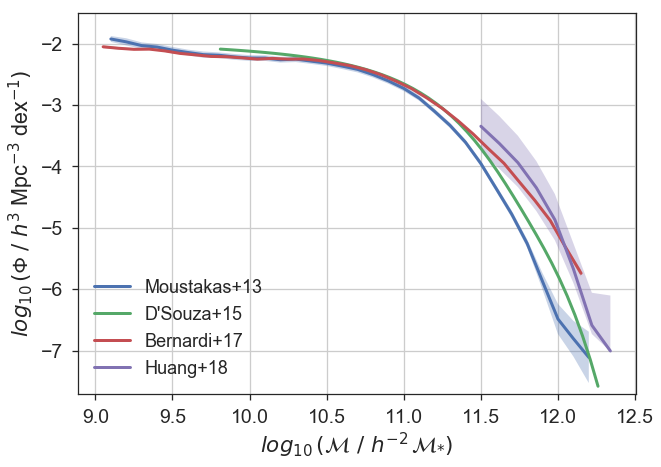

In [19]:
qa_smf(carnage=False, png=os.path.join(talkdir, 'smf-data.png'))

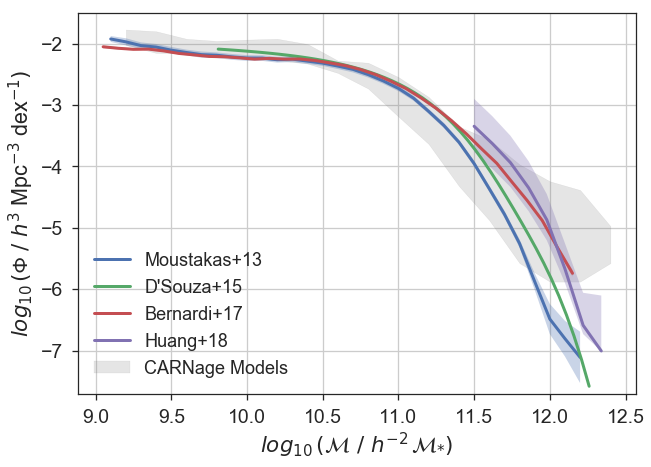

In [20]:
qa_smf(carnage=True, png=os.path.join(talkdir, 'smf-data-carnage.png'))

In [21]:
def qa_smf_huang18(minmax=False, png=None):

    def plot_huang18(ax, cModel=False, BCG=False, label=''):
        mstar, phi, philo, phihi = read_huang18(cModel=cModel, BCG=BCG)
        ax.fill_between(mstar, philo, phihi, alpha=0.3)
        ax.plot(mstar, phi, label=label, lw=3, ls='-')
    
    fig, ax = plt.subplots(figsize=(10, 7))

    # Model shaded region
    # mstar, phimin, phimax = read_model_smf(minmax=True, seed=1)
    # ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray')

    # Data
    plot_huang18(ax, cModel=False, BCG=False, 
                 label=r'$\log\,(\mathcal{M}_h/\mathcal{M}_{\odot})<14.2$')#, $R<100$ kpc')
    #plot_huang18(ax, cModel=True, BCG=False, label=r'$\log\,(M_h/M_{\odot})<14.2$, cModel')
    plot_huang18(ax, cModel=False, BCG=True, 
                 label=r'$\log\,(\mathcal{M}_h/\mathcal{M}_{\odot})>14.2$')#, R<100 kpc$')
    #plot_huang18(ax, cModel=True, BCG=True, label=r'$\log\,(M_h/M_{\odot})>14.2$, cModel')

    ax.set_xlabel(mstar_label())
    ax.set_ylabel(phi_label())
    #ax.set_xlim(11.4, 12.3)
    
    ax.grid()
    ax.legend(loc='upper right', ncol=1, fontsize=18)
    
    if png:
        plt.savefig(png)

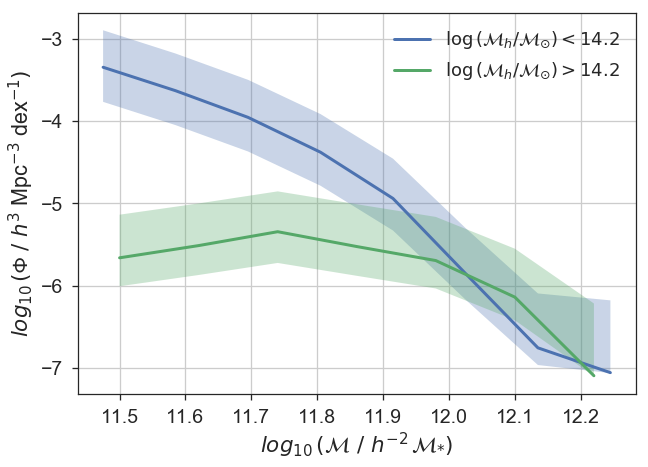

In [22]:
qa_smf_huang18()

In [23]:
stop

NameError: name 'stop' is not defined

### SMHM relation

In [ ]:
def lambda2mhalo(richness, redshift=0.3, Saro=False):
    """
    Convert cluster richness, lambda, to halo mass, given various 
    calibrations.
    
      * Saro et al. 2015: Equation (7) and Table 2 gives M(500).
      * Melchior et al. 2017: Equation (51) and Table 4 gives M(200).
      * Simet et al. 2017: 
    
    Other SDSS-based calibrations: Li et al. 2016; Miyatake et al. 2016; 
    Farahi et al. 2016; Baxter et al. 2016.

    TODO: Return the variance!

    """
    if Saro:
        pass
    
    # Melchior et al. 2017 (default)
    logM0, Flam, Gz, lam0, z0 = 14.371, 1.12, 0.18, 30.0, 0.5
    Mhalo = 10**logM0 * (richness / lam0)**Flam * ( (1 + redshift) / (1 + z0) )**Gz
    
    return Mhalo

In [ ]:
cat = legacyhalos.io.read_catalog(extname='LSPHOT-ISEDFIT', upenn=False, 
                                   isedfit=True, columns=('mstar_avg', 'sfr100_avg'))
cat1 = legacyhalos.io.read_catalog(extname='REDMAPPER', upenn=False, 
                                   isedfit=False, columns=('Z', 'LAMBDA_CHISQ'))
cat.add_columns_from(cat1)
cat

In [ ]:
mhalo = np.log10(lambda2mhalo(cat.lambda_chisq, redshift=cat.z))
mhalo

In [ ]:
bins = 35

In [ ]:
mstar_med, bin_edges, _ = binned_statistic(mhalo, cat.mstar_avg, statistic='median', bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
mhalo_med = bin_edges[1:] - bin_width/2
print(bin_width)

In [ ]:
def p75(x):
    return np.percentile(x, 75)
def p25(x):
    return np.percentile(x, 25)

In [ ]:
mstar_p25, _, _ = binned_statistic(mhalo, cat.mstar_avg, statistic=p25, bins=bins)
mstar_p75, _, _ = binned_statistic(mhalo, cat.mstar_avg, statistic=p75, bins=bins)

In [ ]:
krav = dict()
krav['m500'] = np.log10(np.array([15.6,10.3,7,5.34,2.35,1.86,1.34,0.46,0.47])*1e14)
krav['mbcg'] = np.array([3.12,4.14,3.06,1.47,0.79,1.26,1.09,0.91,1.38])*1e12
krav['mbcg_err'] = np.array([0.36,0.3,0.3,0.13,0.05,0.11,0.06,0.05,0.14])*1e12
krav['mbcg_err'] = krav['mbcg_err'] / krav['mbcg'] / np.log(10)
krav['mbcg'] = np.log10(krav['mbcg'])

In [ ]:
gonz = dict()
gonz['mbcg'] = np.array([0.84,0.87,0.33,0.57,0.85,0.60,0.86,0.93,0.71,0.81,0.70,0.57])*1e12*2.65
gonz['mbcg_err'] = np.array([0.03,0.09,0.01,0.01,0.14,0.03,0.03,0.05,0.07,0.12,0.02,0.01])*1e12*2.65
gonz['m500'] = np.array([2.26,5.15,0.95,3.46,3.59,0.99,0.95,3.23,2.26,2.41,2.37,1.45])*1e14
gonz['m500_err'] = np.array([0.19,0.42,0.1,0.32,0.28,0.11,0.1,0.19,0.23,0.18,0.24,0.21])*1e14
gonz['mbcg_err'] = gonz['mbcg_err'] / gonz['mbcg'] / np.log(10)
gonz['mbcg'] = np.log10(gonz['mbcg'])
gonz['m500'] = np.log10(gonz['m500'])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = iter(sns.color_palette())

rich = cat.lambda_chisq > 100
ax.plot(mhalo_med, mstar_med, color='k', ls='-', lw=3, alpha=0.5)
ax.plot(mhalo_med, mstar_p75, color='k', ls='--', lw=3, alpha=0.5)
ax.plot(mhalo_med, mstar_p25, color='k', ls='--', lw=3, alpha=0.5)

g = ax.errorbar(gonz['m500'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(colors),
                fmt='o', label='Gonzalez+13', markersize=10)
k = ax.errorbar(krav['m500'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(colors),
                fmt='s', label='Kravtsov+14', markersize=10)
r = ax.scatter(mhalo[rich], cat.mstar_avg[rich], alpha=0.9, color=next(colors),
               edgecolor='k', marker='D', s=50, label=r'redMaPPer ($\lambda>100$)')

ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
        transform=ax.transAxes, fontsize=14)
m500 = np.linspace(13.55, 15.25, 50)
ff = ax.plot(m500, np.polyval([0.33, 12.24], m500-14.5), ls='-', 
            color='k', label=r'$M_{*}\propto M_{500}^{0.33}$')
ax.text(0.12, 0.9, r'$M_{*}\propto M_{500}^{0.33}$', multialignment='center',
        transform=ax.transAxes, fontsize=16)
ax.plot([13.55, 13.68], [12.8, 12.8], ls='-', color='k') # hack!!!

#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_locator(MultipleLocator(0.5))

hh = [g, k, r]
ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
          frameon=True, fontsize=16)
#ax.legend(ff, ff.get_label(), loc='upper left',
#          frameon=True, fontsize=16)
#ax.legend(loc='upper left', frameon=True, fontsize=16)

ax.set_ylim(10.5, 13)
ax.set_xlim(13.5, 15.3)
ax.set_xlabel(r'$\log_{10}\, (M_{500}\ /\ M_{\odot})$')
ax.set_ylabel(r'$\log_{10}\, (M_{*}\ /\ M_{\odot})$')

In [ ]:
ff

In [ ]:
stop

In [ ]:
cat

In [ ]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')

In [ ]:
parentfile = os.path.join(legacyhalos_dir, 'legacyhalos-parent-isedfit.fits')

In [ ]:
ls = Table(fits.getdata(parentfile, extname='LSPHOT-ISEDFIT'))
ls

In [ ]:
_ = plt.hist(ls['MSTAR_AVG'], bins=100)

In [ ]:
_ = plt.hist(sdss['MSTAR_AVG'], bins=100)

In [ ]:
_ = plt.hist(sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], bins=200)
plt.xlim(-0.5, 0.5)

In [ ]:
sdss = Table(fits.getdata(parentfile, extname='SDSSPHOT-ISEDFIT'))
sdss

In [ ]:
data = np.vstack( (ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG']))
data.shape

In [ ]:
k = kde.gaussian_kde(data.T)
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [ ]:
fig, ax = plt.subplots()
ax.hexbin(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'],
          mincnt=1)

In [ ]:
sns.jointplot(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], 
              kind="kde", color="#4CB391", xlim=(10, 13), ylim=(-0.5, 0.5))

In [ ]:
sns.kdeplot(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], 
            cmap="Blues", shade=True, shade_lowest=True, cbar=True,
            cut=0,
           )

In [ ]:
help(sns.kdeplot)